In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stockdataset/FPT.csv
/kaggle/input/stockdataset/VIC.csv
/kaggle/input/stockdataset/PNJ.csv
/kaggle/input/stockdataset/MSN.csv


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, List

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.rcParams["figure.dpi"] = 120


In [5]:
# Feature Engineering

def _compute_rsi(series: pd.Series, window: int = 14) -> pd.Series:
    delta = series.diff()
    up = delta.clip(lower=0)
    down = (-delta).clip(lower=0)
    ma_up = up.rolling(window).mean()
    ma_down = down.rolling(window).mean()
    rs = ma_up / (ma_down + 1e-9)
    return 100 - (100 / (1.0 + rs))

def _compute_macd(series: pd.Series, span_s: int = 12, span_l: int = 26, span_sig: int = 9) -> Tuple[pd.Series, pd.Series]:
    ema_fast = series.ewm(span=span_s, min_periods=span_s).mean()
    ema_slow = series.ewm(span=span_l, min_periods=span_l).mean()
    macd = ema_fast - ema_slow
    signal = macd.ewm(span=span_sig, min_periods=span_sig).mean()
    return macd, signal

def _compute_stoch_kd(df: pd.DataFrame, k: int = 14, d: int = 3) -> Tuple[pd.Series, pd.Series]:
    low_min = df["Low"].rolling(k).min()
    high_max = df["High"].rolling(k).max()
    k_pct = 100 * (df["Close"] - low_min) / (high_max - low_min + 1e-9)
    d_pct = k_pct.rolling(d).mean()
    return k_pct, d_pct

def add_technical_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["return1"] = out["Close"].pct_change()
    out["return5"] = out["Close"].pct_change(5)
    out["logret1"] = np.log(out["Close"] / out["Close"].shift(1))
    for w in (5, 10, 20, 50):
        out[f"ma{w}"] = out["Close"].rolling(w).mean()
        out[f"ema{w}"] = out["Close"].ewm(span=w).mean()
    out["boll20"] = (out["Close"] - out["ma20"]) / (out["Close"].rolling(20).std() + 1e-9)
    out["rsi14"] = _compute_rsi(out["Close"], 14)
    macd, macd_sig = _compute_macd(out["Close"])
    out["macd"] = macd
    out["macd_signal"] = macd_sig
    stoch_k, stoch_d = _compute_stoch_kd(out)
    out["stoch_k"] = stoch_k
    out["stoch_d"] = stoch_d

    # Volume features if available
    if "Volume" in out.columns:
        out["logvol"] = np.log(out["Volume"].replace(0, np.nan) + 1)
        out["volchg"] = out["Volume"].pct_change()
        out["vol_ma5"] = out["Volume"].rolling(5).mean()
        out["vol_ma20"] = out["Volume"].rolling(20).mean()
        out["vol_spike"] = out["Volume"] / (out["vol_ma5"] + 1e-9)
    return out

In [6]:
# Data loading & leakage prevention


def load_dataset(path: str) -> pd.DataFrame:
    raw = pd.read_csv(path)
    date_col = next(c for c in ("Date", "Date/Time") if c in raw.columns)
    raw[date_col] = pd.to_datetime(raw[date_col], errors="coerce")
    raw = (
        raw.dropna(subset=[date_col])
        .rename(columns={date_col: "Date"})
        .set_index("Date")
        .sort_index()
    )
    for col in ("Open", "High", "Low", "Close", "Volume"):
        if col in raw.columns:
            raw[col] = pd.to_numeric(raw[col], errors="coerce")
    raw = raw.ffill().bfill()
    enriched = add_technical_features(raw)

    # shift ALL engineered features by +1 day so that only past info is present
    all_feature_cols = enriched.columns.difference(["Close"])
    enriched[all_feature_cols] = enriched[all_feature_cols].shift(1)

    enriched["target"] = enriched["Close"]  # predict absolute close; change if needed
    enriched = enriched.dropna()
    return enriched

In [7]:
# Walk-forward evaluation

def walk_forward_forecast(
    df: pd.DataFrame,
    horizon: int = 60,
    lookback: int = 500,
    refit_step: int = 5,
    min_train: int = 300,
    plot: bool = True,
) -> Tuple[float, float, float]:
    # Lấy đúng feature là numeric
    feature_cols = [
        c for c in df.columns.difference(["Close", "target"])
        if pd.api.types.is_numeric_dtype(df[c])
    ]
    print("Features used for training:", feature_cols)
    scaler = StandardScaler()
    gbm: GradientBoostingRegressor | None = None

    preds: List[float] = []
    naive: List[float] = []
    actual: List[float] = []
    dates = df.index[-horizon:]

    for i, d in enumerate(dates):
        train_end = df.index.get_loc(d) - 1  # up to t‑1
        train_start = max(0, train_end - lookback)
        train = df.iloc[train_start:train_end]
        if len(train) < min_train:
            preds.append(np.nan)
            naive.append(np.nan)
            actual.append(df.loc[d, "target"])
            continue

        if (i % refit_step == 0) or (gbm is None):
            X_train = scaler.fit_transform(train[feature_cols])
            y_train = train["target"].values
            gbm = GradientBoostingRegressor(
                n_estimators=300,
                learning_rate=0.05,
                max_depth=3,
                subsample=0.8,
                random_state=42,
            )
            gbm.fit(X_train, y_train)

        X_test = scaler.transform(df.loc[[d], feature_cols])
        preds.append(float(gbm.predict(X_test)[0]))
        naive.append(float(df.loc[train.index[-1], "Close"]))
        actual.append(float(df.loc[d, "target"]))

    preds_arr = np.array(preds)
    actual_arr = np.array(actual)
    mask = ~np.isnan(preds_arr)
    preds_arr, actual_arr, naive_arr = preds_arr[mask], actual_arr[mask], np.array(naive)[mask]

    rmse = np.sqrt(mean_squared_error(actual_arr, preds_arr))
    mae = mean_absolute_error(actual_arr, preds_arr)
    mape = np.mean(np.abs((actual_arr - preds_arr) / actual_arr)) * 100
    base_rmse = np.sqrt(mean_squared_error(actual_arr, naive_arr))

    print(
        f"RMSE {rmse:.4f}  |  Naïve RMSE {base_rmse:.4f}  (Δ {(base_rmse - rmse)/base_rmse*100:.1f}%)  |  MAPE {mape:.2f}%"
    )

    if plot:
        plt.figure(figsize=(12, 5))
        plt.plot(df.index[-horizon * 4 :], df["Close"].iloc[-horizon * 4 :], label="Actual")
        plt.plot(dates, preds, label="GBM")
        plt.plot(dates, naive, "--", alpha=0.6, label="Naïve")
        plt.axvline(dates[0], color="k", linestyle="--")
        plt.title("Walk‑forward forecast")
        plt.legend()
        plt.tight_layout()
        plt.grid(alpha=0.3)
        plt.show()

    return rmse, mae, mape

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


FPT.csv
Features used for training: ['High', 'Low', 'Open', 'Open Interest', 'Volume', 'boll20', 'ema10', 'ema20', 'ema5', 'ema50', 'logret1', 'logvol', 'ma10', 'ma20', 'ma5', 'ma50', 'macd', 'macd_signal', 'return1', 'return5', 'rsi14', 'stoch_d', 'stoch_k', 'vol_ma20', 'vol_ma5', 'vol_spike', 'volchg']
RMSE 0.1534  |  Naïve RMSE 0.1008  (Δ -52.2%)  |  MAPE 0.20%


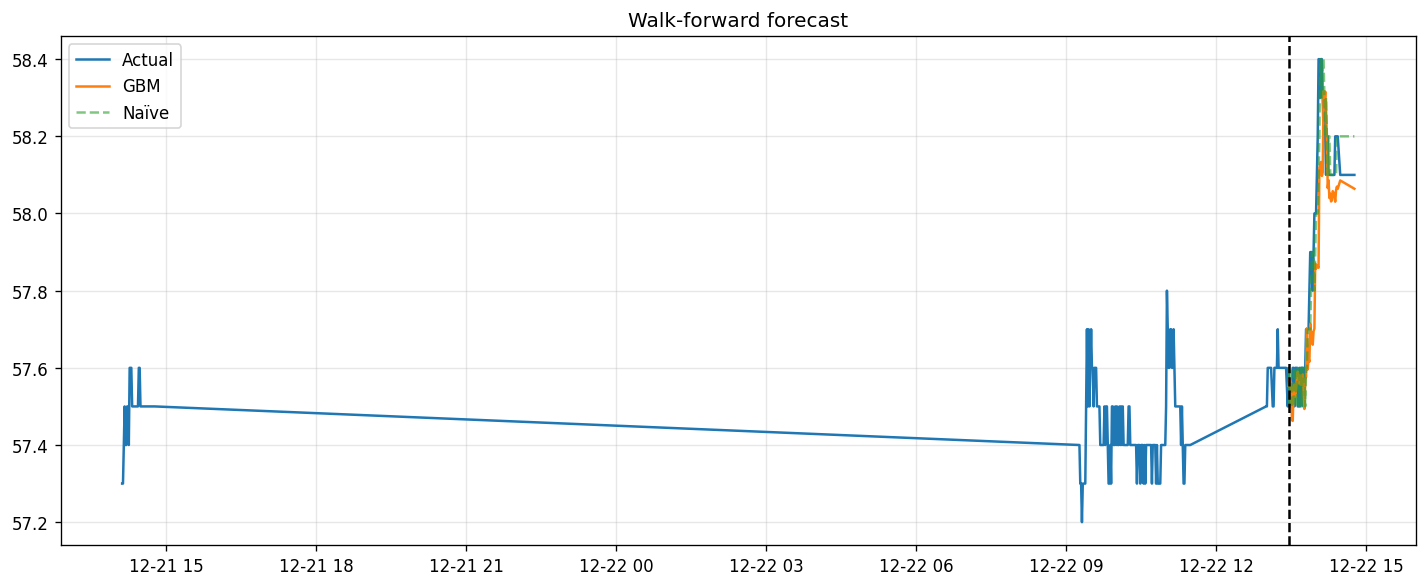

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


MSN.csv
Features used for training: ['High', 'Low', 'Open', 'Open Interest', 'Volume', 'boll20', 'ema10', 'ema20', 'ema5', 'ema50', 'logret1', 'logvol', 'ma10', 'ma20', 'ma5', 'ma50', 'macd', 'macd_signal', 'return1', 'return5', 'rsi14', 'stoch_d', 'stoch_k', 'vol_ma20', 'vol_ma5', 'vol_spike', 'volchg']
RMSE 0.0738  |  Naïve RMSE 0.0806  (Δ 8.5%)  |  MAPE 0.07%


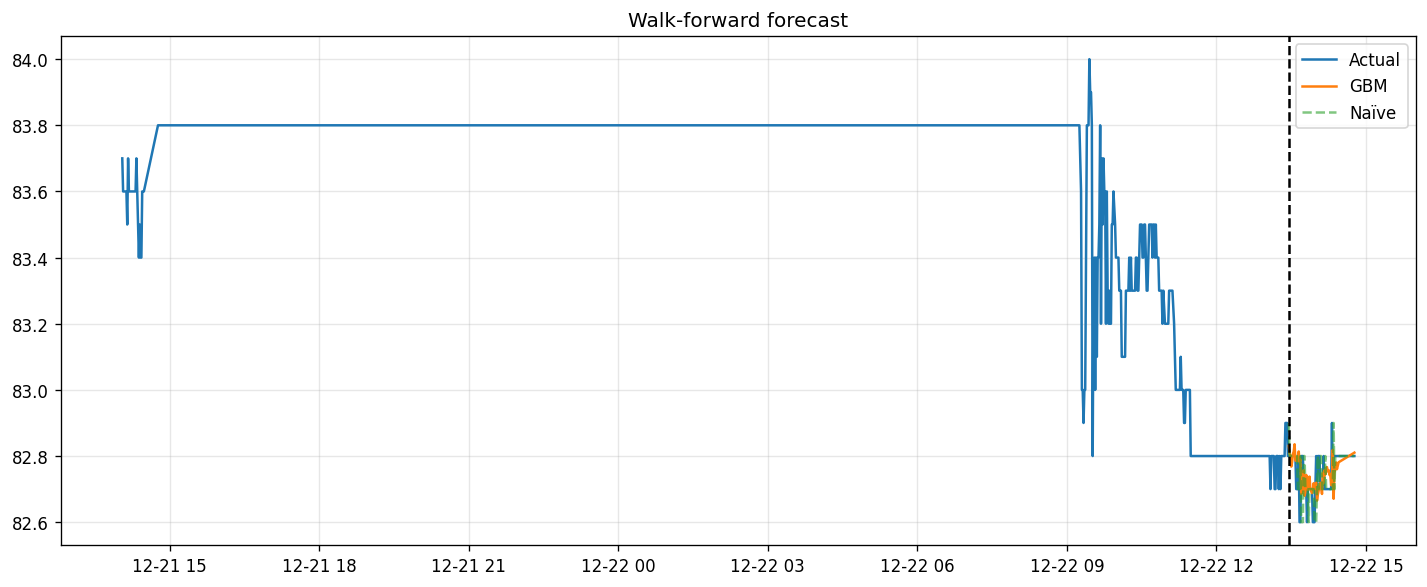

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


PNJ.csv
Features used for training: ['High', 'Low', 'Open', 'Open Interest', 'Volume', 'boll20', 'ema10', 'ema20', 'ema5', 'ema50', 'logret1', 'logvol', 'ma10', 'ma20', 'ma5', 'ma50', 'macd', 'macd_signal', 'return1', 'return5', 'rsi14', 'stoch_d', 'stoch_k', 'vol_ma20', 'vol_ma5', 'vol_spike', 'volchg']
RMSE 0.0881  |  Naïve RMSE 0.0876  (Δ -0.6%)  |  MAPE 0.09%


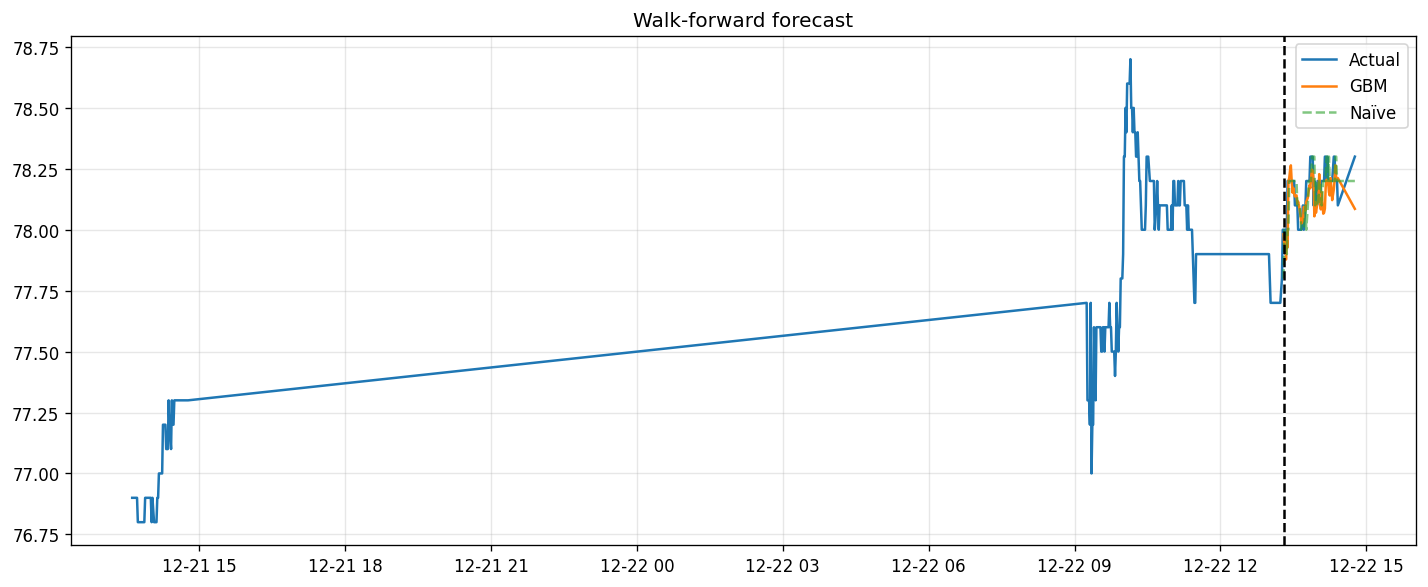

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


VIC.csv
Features used for training: ['High', 'Low', 'Open', 'Open Interest', 'Volume', 'boll20', 'ema10', 'ema20', 'ema5', 'ema50', 'logret1', 'logvol', 'ma10', 'ma20', 'ma5', 'ma50', 'macd', 'macd_signal', 'return1', 'return5', 'rsi14', 'stoch_d', 'stoch_k', 'vol_ma20', 'vol_ma5', 'vol_spike', 'volchg']
RMSE 0.0917  |  Naïve RMSE 0.1118  (Δ 17.9%)  |  MAPE 0.06%


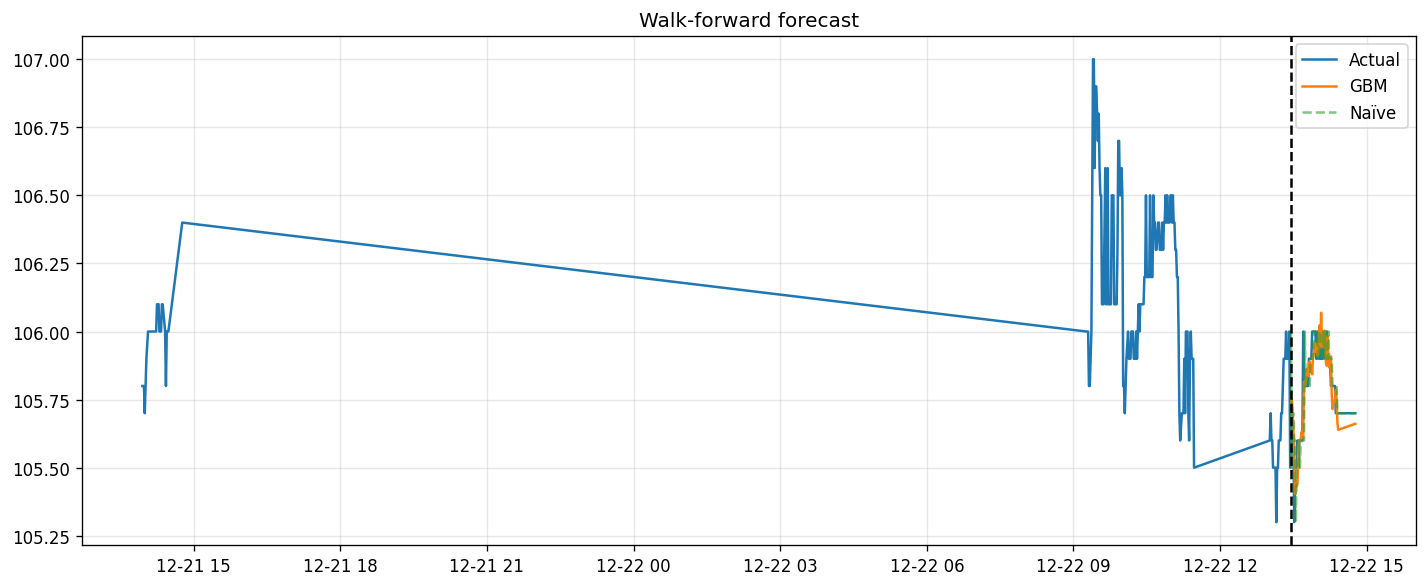

In [8]:
def run_pipeline(csv_path: str, **kwargs):
    df = load_dataset(csv_path)
    print(os.path.basename(csv_path))
    return walk_forward_forecast(df, **kwargs)

if __name__ == "__main__":
    for ticker in ("FPT", "MSN", "PNJ", "VIC"):
        run_pipeline(f'/kaggle/input/stockdataset/{ticker}.csv', horizon=60, refit_step=5, plot=True)